## Download das bibliotecas

In [2]:
using JuMP,Ipopt,MosekTools, PyPlot
ipopt = () -> Ipopt.Optimizer()
mosek = () -> Mosek.Optimizer()

#5 (generic function with 1 method)

## Estrutura de Dados e Funções auxiliares

In [3]:
include("../src/structs.jl")
include("../src/data_read.jl")
include("../src/utils.jl")

graph_dispersion (generic function with 1 method)

Fonte de dados: [pglib-opf-master](https://github.com/power-grid-lib/pglib-opf)

In [4]:
full_data = "C:\\Users\\rafabench\\Downloads\\pglib-opf-master\\"

"C:\\Users\\rafabench\\Downloads\\pglib-opf-master\\"

# Construção do Modelo

## Constantes

In [5]:
function add_constants(Branches)
    YR = zeros(length(Branches))
    YI = zeros(length(Branches))
    TR = zeros(length(Branches))
    TI = zeros(length(Branches))
    B = zeros(length(Branches))
    thermal_lim = zeros(length(Branches))
    ang_min = zeros(length(Branches))
    ang_max = zeros(length(Branches))
    for l=1:length(Branches)
        YR[l] = Branches[l].r/(Branches[l].r^2+Branches[l].x^2)
        YI[l] = -Branches[l].x/(Branches[l].r^2+Branches[l].x^2)
        TR[l] = Branches[l].ratio*cos(Branches[l].angle)
        TI[l] = Branches[l].ratio*sin(Branches[l].angle)
        B[l] = Branches[l].b
        thermal_lim[l] = Branches[l].rateA/100.0
        ang_min[l] = Branches[l].angmin*pi/180
        ang_max[l] = Branches[l].angmax*pi/180
    end
    return YR,YI,TR,TI,B,thermal_lim,ang_min,ang_max
end

add_constants (generic function with 1 method)

## Variáveis que não serão relaxadas

In [6]:
function add_global_variables!(model, Buses, Generators, Branches, thermal_lim; start=false)
    if start
        arr1 = ones(length(Buses))
        arr2 = ones(length(Generators))
        arr3 = ones(length(Branches))
        @variable(model, Generators[i].Pmin/100.0 <= p_g[i=1:length(Generators)] <= Generators[i].Pmax/100.0, start = arr2[i])
        @variable(model, Generators[i].Qmin/100.0 <= q_g[i=1:length(Generators)] <= Generators[i].Qmax/100.0, start = arr2[i])
        SR = @variable(model,[(i,j,l) in [(i,j,l) for i = 1:length(Buses) for (j,l) in zip(δ(i,Branches,Buses)...)]], base_name = "SR",lower_bound = -thermal_lim[l], upper_bound = thermal_lim[l], start = arr3[l])
        SI = @variable(model,[(i,j,l) in [(i,j,l) for i = 1:length(Buses) for (j,l) in zip(δ(i,Branches,Buses)...)]], base_name = "SI",lower_bound = -thermal_lim[l], upper_bound = thermal_lim[l], start = arr3[l])
    else
        @variable(model, Generators[i].Pmin/100.0 <= p_g[i=1:length(Generators)] <= Generators[i].Pmax/100.0)
        @variable(model, Generators[i].Qmin/100.0 <= q_g[i=1:length(Generators)] <= Generators[i].Qmax/100.0)
        SR = @variable(model,[(i,j,l) in [(i,j,l) for i = 1:length(Buses) for (j,l) in zip(δ(i,Branches,Buses)...)]], base_name = "SR",lower_bound = -thermal_lim[l], upper_bound = thermal_lim[l])
        SI = @variable(model,[(i,j,l) in [(i,j,l) for i = 1:length(Buses) for (j,l) in zip(δ(i,Branches,Buses)...)]], base_name = "SI",lower_bound = -thermal_lim[l], upper_bound = thermal_lim[l])
    end
    model[:SR] = SR
    model[:SI] = SI
end

add_global_variables! (generic function with 1 method)

## Variáveis de voltagem

In [7]:
function add_voltage_variables!(model, Buses; start = false)
    if start
        arr1 = ones(length(Buses))
        @variable(model, - Buses[i].Vmax <= VR[i=1:length(Buses)] <= Buses[i].Vmax , start = arr1[i])
        @variable(model, - Buses[i].Vmax <= VI[i=1:length(Buses)] <= Buses[i].Vmax , start = arr1[i])
    else
        @variable(model, - Buses[i].Vmax <= VR[i=1:length(Buses)] <= Buses[i].Vmax)
        @variable(model, - Buses[i].Vmax <= VI[i=1:length(Buses)] <= Buses[i].Vmax)
    end
end

add_voltage_variables! (generic function with 1 method)

## Restrições

In [8]:
function add_reference_angle!(model, Buses)
    VI = variable_by_name(model, "VI[1]")
    @constraint(model, VI == 0)
end

add_reference_angle! (generic function with 1 method)

In [9]:
function constraint_power_balance!(model, Buses, Generators, Branches, sqrd_volt, i)
    p_g = model[Symbol("p_g")]
    q_g = model[Symbol("q_g")]
    SR = model[Symbol("SR")]
    SI = model[Symbol("SI")]
    @constraint(model, sum(p_g[i] for i in G(i,Generators,Buses)) - Buses[i].Pd/100.0 + Buses[i].Gs/100.0*sqrd_volt == sum(SR[(i,j,l)] for (j,l) in zip(δ(i,Branches,Buses)...)))
    @constraint(model, sum(q_g[i] for i in G(i,Generators,Buses)) - Buses[i].Qd/100.0 + Buses[i].Bs/100.0*sqrd_volt == sum(SI[(i,j,l)] for (j,l) in zip(δ(i,Branches,Buses)...)))
end

constraint_power_balance! (generic function with 1 method)

In [10]:
function voltage_bounds_sqrd!(model, Buses, sqrd_volt, i)
    @constraint(model, Buses[i].Vmin^2 <= sqrd_volt <= Buses[i].Vmax^2)
end

voltage_bounds_sqrd! (generic function with 1 method)

In [11]:
function constraint_line_balance!(model, YR, YI, B, sqrd_volt_i, sqrd_volt_j, sum_product_voltages,  diff_product_voltages, i, j, l)
    SR = model[Symbol("SR")]
    SI = model[Symbol("SI")]
    
    @constraint(model, SR[(i,j,l)] == YR*sqrd_volt_i + (-YR)*sum_product_voltages + (-YI)*(diff_product_voltages))
            
    @constraint(model, SI[(i,j,l)] == -(YI+B/2)*sqrd_volt_i - (-YI)*sum_product_voltages + (-YR)*diff_product_voltages)

    @constraint(model, SR[(j,i,l)] == YR*sqrd_volt_j + (-YR)*sum_product_voltages + (-YI)*(-(diff_product_voltages)))

    @constraint(model, SI[(j,i,l)] == -(YI+B/2)*sqrd_volt_j - (-YI)*sum_product_voltages + (-YR)*(-(diff_product_voltages)))
end

constraint_line_balance! (generic function with 1 method)

In [12]:
function line_thermal_bounds_sqrd!(model,thermal_lim, i, j, l)
    SR = model[Symbol("SR")]
    SI = model[Symbol("SI")]
    
    @constraint(model, SI[(i,j,l)]^2+SR[(i,j,l)]^2 <= thermal_lim[l]^2)
    @constraint(model, SI[(j,i,l)]^2+SR[(j,i,l)]^2 <= thermal_lim[l]^2)
end

line_thermal_bounds_sqrd! (generic function with 1 method)

In [13]:
function constraint_phase_angle_diff!(model, ang_max, ang_min, sum_product_voltages,  diff_product_voltages, i, j, l) 
    @constraint(model, diff_product_voltages <= tan(ang_max[l])*sum_product_voltages)
    @constraint(model, diff_product_voltages >= tan(ang_min[l])*sum_product_voltages)
end

constraint_phase_angle_diff! (generic function with 1 method)

## Função Objetivo

In [14]:
function add_objective!(model, GeneratorCosts)
    p_g = model[Symbol("p_g")]
    q_g = model[Symbol("q_g")]
    obj = sum([GeneratorCosts[k].c2*p_g[k]^2*100.0^2+GeneratorCosts[k].c1*p_g[k]*100.0+GeneratorCosts[k].c0 for k = 1:length(GeneratorCosts)])
    @objective(model, Min, obj)
end

add_objective! (generic function with 1 method)

## Funções relacionadas com o grafo da rede elétrica

In [15]:
function bus_id(Buses)
    count = 1
    dict_buses = Dict()
    for bus in Buses
        dict_buses[bus.bus_i] = count
        count += 1
    end
    dict_buses
end

bus_id (generic function with 1 method)

In [16]:
function δ(i,Branches,Buses)
    tbuses = []
    dict_buses = bus_id(Buses)
    count = 1
    ls = []
    for branch in Branches
        if dict_buses[branch.fbus] == i
            push!(tbuses,dict_buses[branch.tbus])
            push!(ls,count)
        end
        if dict_buses[branch.tbus] == i
            push!(tbuses,dict_buses[branch.fbus])
            push!(ls,count)
        end
        count += 1
    end
    (tbuses,ls)
end

δ (generic function with 1 method)

In [17]:
function From_nodes(i,Branches,Buses)
    tbuses = []
    ls = []
    count = 1
    dict_buses = bus_id(Buses)
    for branch in Branches
        if dict_buses[branch.fbus] == i
            push!(tbuses,dict_buses[branch.tbus])
            push!(ls,count)
        end
        count += 1
    end
    (tbuses,ls)
end

function To_nodes(i,Branches,Buses)
    tbuses = []
    ls = []
    count = 1
    dict_buses = bus_id(Buses)
    for branch in Branches
        if dict_buses[branch.tbus] == i
            push!(tbuses,dict_buses[branch.fbus])
            push!(ls,count)
        end
        count += 1
    end
    (tbuses,ls)
end

To_nodes (generic function with 1 method)

In [18]:
function G(i,Generators,Buses)
    G_i = []
    count = 1
    dict_buses = bus_id(Buses)
    for gen in Generators
        if dict_buses[gen.bus] == i
            push!(G_i,count)
        end
        count += 1
    end
    G_i
end

G (generic function with 1 method)

# Relaxações Convexas

## Envelopes de McCormick

### Função para construir os envelopes de McCormick

In [19]:
function MC_Envelopes!(model,w,x,y)
    x_up = upper_bound(x) 
    x_down = lower_bound(x)
    y_up = upper_bound(y) 
    y_down = lower_bound(y)
    @constraint(model, y_down*x+x_down*y-x_down*y_down <= w)
    @constraint(model, w <= y_down*x+x_up*y-x_up*y_down)
    @constraint(model, y_up*x+x_up*y-x_up*y_up <= w)
    @constraint(model, w <= y_up*x+x_down*y-x_down*y_up)
end

MC_Envelopes! (generic function with 1 method)

### Relaxação com os envelopes de McCormick

In [20]:
function MC_relaxation!(model,Buses,Branches)
    VR = model[Symbol("VR")]
    VI = model[Symbol("VI")]
    @variable(model, W[i=1:2*length(Buses),j=1:2*length(Buses)])
    s = x -> x+length(Buses)
    sqrd_volt = [W[i,i]+W[s(i),s(i)] for i=1:length(Buses)]
    for i=1:length(Buses)
        MC_Envelopes!(model, W[i,i], VR[i], VR[i])
        MC_Envelopes!(model, W[s(i),s(i)], VI[i], VI[i])
    end
    for i=1:length(Buses)
        for (j,l) in zip(From_nodes(i,Branches,Buses)...)    
            MC_Envelopes!(model,W[i,j]      ,VR[i],VR[j])
            MC_Envelopes!(model,W[s(i),s(j)],VI[i],VI[j])
            MC_Envelopes!(model,W[s(i),j]   ,VI[i],VR[j])
            MC_Envelopes!(model,W[j,i]      ,VR[j],VR[i])
            MC_Envelopes!(model,W[s(j),s(i)],VI[j],VI[i])
            MC_Envelopes!(model,W[j,s(i)]   ,VR[i],VI[j])
        end
    end
end

MC_relaxation! (generic function with 1 method)

## Relaxação SDP

In [21]:
function SDP_relaxation!(model,Buses)
    @variable(model, W[i=1:2*length(Buses),j=1:2*length(Buses)],PSD)
end

SDP_relaxation! (generic function with 1 method)

## Relaxação SOCP

In [22]:
function SOCP_relaxation!(model,Buses,Branches)
    @variable(model, W[i=1:2*length(Buses),j=1:2*length(Buses)])
    s = x -> x+length(Buses)
    for i=1:length(Buses)
        for (j,l) in zip(From_nodes(i,Branches,Buses)...)
            @constraint(model, [W[i,i]+W[s(i),s(i)]+W[j,j]+W[s(j),s(j)], 2*(W[i,j]+W[s(i),s(j)]), W[i,i]+W[s(i),s(i)]-W[j,j]-W[s(j),s(j)]] in SecondOrderCone())
        end
    end
end

SOCP_relaxation! (generic function with 1 method)

# Modelo Completo

In [23]:
function build_problem(file::String, optimizer, relaxation::RELAXATION)
    Buses, Generators, GeneratorCosts, Branches = read_matlab_file(file);
    YR,YI,TR,TI,B,thermal_lim,ang_min,ang_max = add_constants(Branches)
    model = Model(optimizer)
    if relaxation == NL
        add_global_variables!(model, Buses, Generators, Branches, thermal_lim, start = true)
    else
        add_global_variables!(model, Buses, Generators, Branches, thermal_lim)
    end
    add_objective!(model, GeneratorCosts)
    
    if relaxation == NL 
        add_voltage_variables!(model, Buses, start = true)
    elseif relaxation == MC
        add_voltage_variables!(model, Buses)
    end
    if relaxation == NL || relaxation == MC
        add_reference_angle!(model, Buses)
        VR = model[Symbol("VR")]
        VI = model[Symbol("VI")]
    end
    
    if relaxation == NL
        sqrd_volt = VR.^2 .+ VI.^2
    end
    
        
    if relaxation == MC
        MC_relaxation!(model,Buses,Branches)
    end
    if relaxation == SDP
        SDP_relaxation!(model,Buses)
    end
    if relaxation == SOCP
        SOCP_relaxation!(model,Buses,Branches)
    end
    
    if relaxation == MC || relaxation == SDP || relaxation == SOCP
        W = model[Symbol("W")]
        s = x -> x+length(Buses)
        sqrd_volt = [W[i,i]+W[s(i),s(i)] for i=1:length(Buses)]
    end
    
    for i=1:length(Buses)
        constraint_power_balance!(model, Buses, Generators, Branches, sqrd_volt[i], i)
        voltage_bounds_sqrd!(model, Buses, sqrd_volt[i], i)
    end
    
    for i=1:length(Buses)
        for (j,l) in zip(From_nodes(i,Branches,Buses)...)
            if relaxation == NL
                sum_product_voltages  = VR[i]*VR[j]+VI[i]*VI[j]
                diff_product_voltages = VI[i]*VR[j]-VR[i]*VI[j]
            elseif relaxation == MC || relaxation == SDP || relaxation == SOCP
                sum_product_voltages  = W[i,j]+W[s(i),s(j)]
                diff_product_voltages = W[s(j),i]-W[s(i),j]
            end
            constraint_line_balance!(model, YR[l], YI[l], B[l], sqrd_volt[i], sqrd_volt[j], sum_product_voltages,  diff_product_voltages, i, j, l)
            constraint_phase_angle_diff!(model, ang_max, ang_min, sum_product_voltages, diff_product_voltages, i, j, l)
            line_thermal_bounds_sqrd!(model,thermal_lim, i, j, l)
        end
    end
    return model
end

build_problem (generic function with 1 method)

# Testes

## Caso 5 barras

$|\mathcal{B}| = 5 $

$|\mathcal{L}| = 6 $

$|\mathcal{G}| = 5 $

In [24]:
optimal_value = 1.7552e4

17552.0

### Não linear - Ipopt

In [25]:
file = full_data*tests[5]
model_nl = build_problem(file,ipopt,NL);

In [26]:
optimize!(model_nl)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      299
Number of nonzeros in inequality constraint Jacobian.:      140
Number of nonzeros in Lagrangian Hessian.............:      236

Total number of variables............................:       44
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       44
                     variables with only upper bounds:        0
Total number of equa

In [27]:
optimality_gap(model_nl,optimal_value)

0.0006219265169926132

### Relaxação de McCormick - MOSEK

In [28]:
file = full_data*tests[5]
model_mc = build_problem(file,mosek,MC);

In [29]:
optimize!(model_mc)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 286             
  Cones                  : 13              
  Scalar variables       : 147             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 16
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
Problem
  Name                   :                 
  Objective s

In [30]:
optimality_gap_mosek(model_mc,optimal_value,file)

37.99572584555339

### Relaxação SDP - MOSEK

In [31]:
file = full_data*tests[5]
model_sdp = build_problem(file,mosek,SDP);

In [32]:
optimize!(model_sdp)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 101             
  Cones                  : 13              
  Scalar variables       : 85              
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimizat

In [33]:
optimality_gap_mosek(model_sdp,optimal_value,file)

5.220024821741412

### Relaxação SOCP - MOSEK

In [34]:
file = full_data*tests[5]
model_socp = build_problem(file,mosek,SOCP);

In [35]:
optimize!(model_socp)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 119             
  Cones                  : 19              
  Scalar variables       : 137             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 17
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
Problem
  Name                   :                 
  Objective s

In [36]:
optimality_gap_mosek(model_socp,optimal_value,file)

15.603662703174829

### Avaliação dos Resultados

In [37]:
models = [model_nl,model_mc,model_sdp,model_socp];

In [38]:
function plot_var(models,variable,title,y_label)
    fig = figure(1)
    ax = fig.add_subplot(1,1,1)
    vars = [value.(model[Symbol(variable)]) for model in models]
    var_length = length(vars[1])
    models_type = ["NL","MC","SDP","SOCP"]
    width = 0.15
    G_labels = ["G"*string(i) for i = 1:var_length]
    xs = 1:var_length
    for (i,var) in enumerate(vars)
        ax.bar(xs.+(i-2.5)*width,var,width,label = models_type[i])
    end
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_xticks(xs)
    ax.set_xticklabels(G_labels)
    ax.legend()
    return fig
end

plot_var (generic function with 1 method)

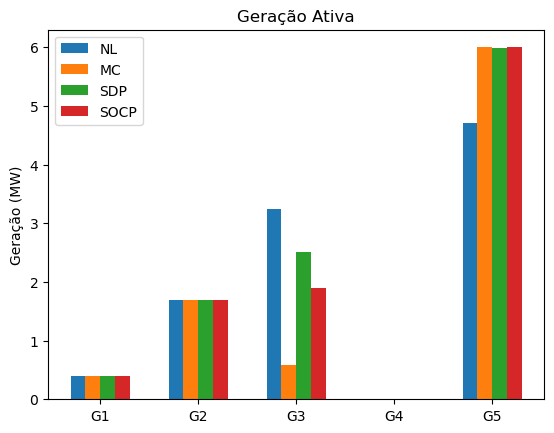

In [39]:
plot_var(models,"p_g","Geração Ativa","Geração (MW)");

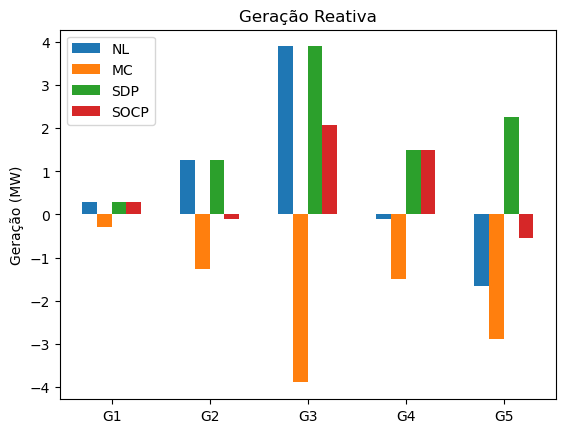

In [40]:
plot_var(models,"q_g","Geração Reativa","Geração (MW)");

## Caso 39 barras

$|\mathcal{B}| = 39 $

$|\mathcal{L}| = 46 $

$|\mathcal{G}| = 10 $

In [41]:
optimal_value = 1.3842e5

138420.0

### Não linear - Ipopt

In [42]:
file = full_data*tests[39]
model_nl = build_problem(file,ipopt,NL);

In [43]:
optimize!(model_nl)

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2149
Number of nonzeros in inequality constraint Jacobian.:     1076
Number of nonzeros in Lagrangian Hessian.............:     1764

Total number of variables............................:      282
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      282
                     variables with only upper bounds:        0
Total number of equality constraints.................:      263
Total number of inequality constraints...............:      262
        inequality constraints with only lower bounds:       85
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      177

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [44]:
optimality_gap(model_nl,optimal_value)

-0.02933882657299528

### Relaxação de McCormick - MOSEK

In [45]:
file = full_data*tests[39]
model_mc = build_problem(file,mosek,MC);

In [46]:
optimize!(model_mc)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2180            
  Cones                  : 93              
  Scalar variables       : 1053            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 132
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 9
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective 

In [47]:
optimality_gap_mosek(model_mc,optimal_value,file)

26.36069206631333

### Relaxação SDP - MOSEK

In [48]:
file = full_data*tests[39]
model_sdp = build_problem(file,mosek,SDP);

In [49]:
optimize!(model_sdp)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 763             
  Cones                  : 93              
  Scalar variables       : 575             
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 9
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimizat

In [50]:
optimality_gap_mosek(model_sdp,optimal_value,file)

0.018958022811812986

### Relaxação SOCP - MOSEK

In [51]:
file = full_data*tests[39]
model_socp = build_problem(file,mosek,SOCP);

In [52]:
optimize!(model_socp)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 901             
  Cones                  : 139             
  Scalar variables       : 975             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 177
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 5
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 131             
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective 

In [53]:
optimality_gap_mosek(model_socp,optimal_value,file)

1.618986312063419

### Avaliação dos Resultados

In [54]:
models = [model_nl,model_mc,model_sdp,model_socp];

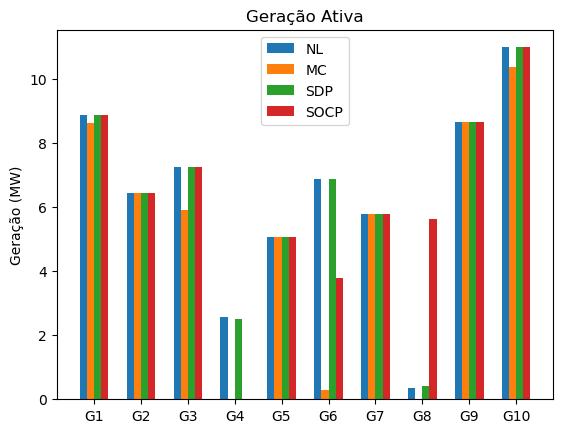

In [55]:
plot_var(models,"p_g","Geração Ativa","Geração (MW)");

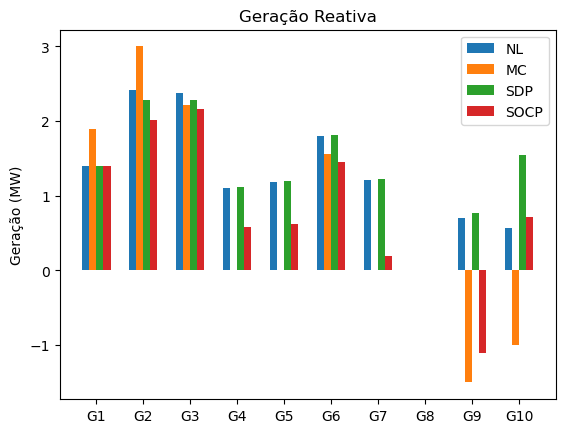

In [56]:
plot_var(models,"q_g","Geração Reativa","Geração (MW)");

## Caso 162 barras

$|\mathcal{B}| = 162 $

$|\mathcal{L}| = 284 $

$|\mathcal{G}| = 12 $

In [57]:
optimal_value = 1.0808e5

108080.0

### Não linear - Ipopt

In [58]:
file = full_data*tests[162]
model_nl = build_problem(file,ipopt,NL);

In [59]:
optimize!(model_nl)

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    13065
Number of nonzeros in inequality constraint Jacobian.:     6328
Number of nonzeros in Lagrangian Hessian.............:    10544

Total number of variables............................:     1484
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1484
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1461
Total number of inequality constraints...............:     1460
        inequality constraints with only lower bounds:      446
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     1014

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [60]:
optimality_gap(model_nl,optimal_value)

0.7040320218128626

### Relaxação de McCormick - MOSEK

In [61]:
file = full_data*tests[162]
model_mc = build_problem(file,mosek,MC);

In [62]:
optimize!(model_mc)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 12577           
  Cones                  : 569             
  Scalar variables       : 6043            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 704
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 28
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.05    
Problem
  Name                   :                 
  Objective

In [63]:
optimality_gap_mosek(model_mc,optimal_value,file)

81.46095982277905

### Relaxação SDP - MOSEK

In [64]:
file = full_data*tests[162]
model_sdp = build_problem(file,mosek,SDP);

In [65]:
optimize!(model_sdp)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4464            
  Cones                  : 569             
  Scalar variables       : 3435            
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 11
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.03    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimiza

65  4.8e-07  6.0e-06  1.9e-06  9.76e-01   1.065533110e+05   1.065532995e+05   2.2e-09  16.45 
66  3.6e-07  4.6e-06  1.3e-06  9.74e-01   1.065829477e+05   1.065829395e+05   1.7e-09  16.69 
67  2.7e-08  3.4e-07  2.8e-08  9.89e-01   1.066759361e+05   1.066759358e+05   1.2e-10  16.95 
68  2.2e-09  2.8e-08  6.7e-10  9.99e-01   1.066833414e+05   1.066833414e+05   1.0e-11  17.27 
69  3.0e-11  1.2e-06  1.1e-12  1.00e+00   1.066840006e+05   1.066840006e+05   1.4e-13  17.52 
Optimizer terminated. Time: 17.55   



In [66]:
optimality_gap_mosek(model_sdp,optimal_value,file)

1.291635243539082

### Relaxação SOCP - MOSEK

In [67]:
file = full_data*tests[162]
model_socp = build_problem(file,mosek,SOCP);

In [68]:
optimize!(model_socp)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5316            
  Cones                  : 853             
  Scalar variables       : 5731            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 1041
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 70
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 722             
Presolve terminated. Time: 0.01    
Problem
  Name                   :                 
  Objectiv

65  1.1e-02  9.6e-03  2.4e-02  7.46e-01   9.262649117e+04   9.261316164e+04   5.0e-06  0.42  
66  5.2e-03  4.3e-03  8.2e-03  8.52e-01   9.517594190e+04   9.516977948e+04   2.3e-06  0.44  
67  2.8e-03  2.4e-03  3.4e-03  9.44e-01   9.631878515e+04   9.631542201e+04   1.2e-06  0.44  
68  1.1e-03  8.9e-04  8.5e-04  9.74e-01   9.722228377e+04   9.722102070e+04   4.6e-07  0.44  
69  2.8e-04  2.4e-04  1.2e-04  9.93e-01   9.764964939e+04   9.764931657e+04   1.2e-07  0.44  
70  1.3e-04  1.1e-04  3.8e-05  9.99e-01   9.773552035e+04   9.773536925e+04   5.6e-08  0.44  
71  4.0e-05  3.4e-05  6.8e-06  9.99e-01   9.778577240e+04   9.778572564e+04   1.7e-08  0.45  
72  1.8e-05  1.5e-05  2.0e-06  9.99e-01   9.779878491e+04   9.779876414e+04   7.8e-09  0.45  
73  5.7e-06  4.7e-06  3.7e-07  9.99e-01   9.780594759e+04   9.780594100e+04   2.5e-09  0.47  
74  2.6e-06  2.2e-06  1.2e-07  1.00e+00   9.780778053e+04   9.780777752e+04   1.1e-09  0.47  
75  6.8e-07  6.1e-07  1.6e-08  1.00e+00   9.780892872e+04   

In [69]:
optimality_gap_mosek(model_socp,optimal_value,file)

9.502853927527452

### Avaliação dos Resultados

In [70]:
models = [model_nl,model_mc,model_sdp,model_socp];

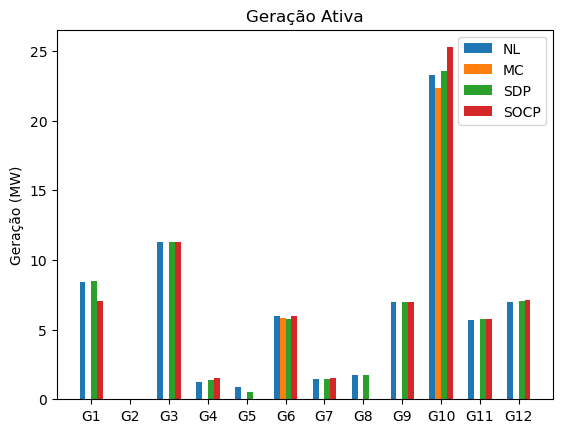

In [71]:
plot_var(models,"p_g","Geração Ativa","Geração (MW)");

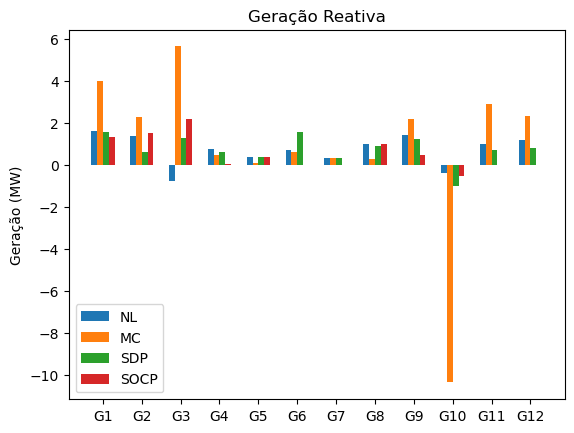

In [72]:
plot_var(models,"q_g","Geração Reativa","Geração (MW)");

# Tabela de Resultados

## $|\mathcal{B}| \leq 500 $

In [73]:
files = [tests[i] for i in [3,5,14,24,30,39,57,73,89,118,162,179,240,300,500]]
cases = benchmark(files,tests);

In [74]:
print_cases_table(cases)

                  Tabela de estimativa de erro em percentual

               Nome do Arquivo |      NL |      MC |     SDP |    SOCP |
        pglib_opf_case3_lmbd.m |   0.001 |  39.649 |   0.390 |   2.987 |
         pglib_opf_case5_pjm.m |   0.001 |  37.996 |   5.220 |  15.604 |
       pglib_opf_case14_ieee.m |   0.027 | 100.000 |   0.027 |   5.433 |
   pglib_opf_case24_ieee_rts.m |   0.002 |  25.282 |   0.002 |   3.639 |
       pglib_opf_case30_ieee.m |   0.193 | 100.000 |   0.193 |  30.315 |
       pglib_opf_case39_epri.m |   0.029 |  26.361 |   0.019 |   1.619 |
       pglib_opf_case57_ieee.m |   3.517 | 100.000 | 100.000 |   7.275 |
   pglib_opf_case73_ieee_rts.m |   0.004 |  28.183 |   0.004 |   3.488 |
     pglib_opf_case89_pegase.m |   0.058 |  54.010 |   0.428 |   2.701 |
      pglib_opf_case118_ieee.m |   0.011 |  95.029 |   0.066 |   4.227 |
  pglib_opf_case162_ieee_dtc.m |   0.704 |  81.461 |   1.292 |   9.503 |
       pglib_opf_case179_goc.m |   0.014 |   5.737 |   0.086 |

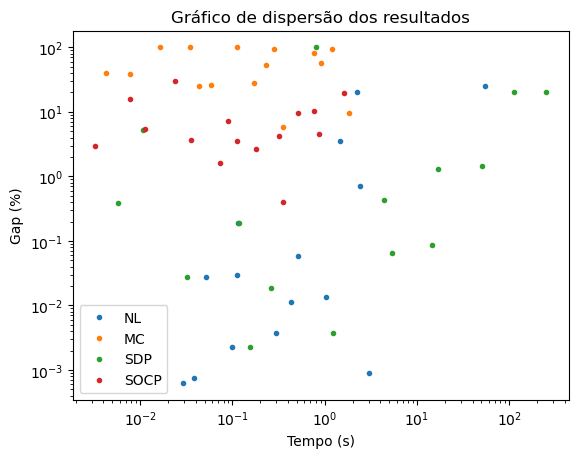

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [76]:
graph_dispersion(cases)

## $1354 \leq |\mathcal{B}| \leq 3375 $

In [375]:
files = [tests[i] for i in [1354,1888, 1951, 2000, 2316,2736,3012,3375]]
cases_no_sdp = benchmark_no_sdp(files,tests);

In [378]:
print_cases_no_sdp_table(cases_no_sdp)

             Tabela de estimativa de erro em percentual

               Nome do Arquivo |       NL |       MC |     SOCP |
   pglib_opf_case1354_pegase.m |    0.127 |   61.633 |    4.535 |
      pglib_opf_case1888_rte.m |   20.670 |   51.178 |    4.766 |
      pglib_opf_case1951_rte.m |   25.710 |   58.784 |    2.808 |
     pglib_opf_case2000_tamu.m |    5.404 |   33.885 |    3.228 |
     pglib_opf_case2316_sdet.m |    1.262 |   37.722 |    3.492 |
      pglib_opf_case2736sp_k.m |    8.609 |    8.609 |    8.609 |
      pglib_opf_case3012wp_k.m |    1.825 |   35.034 |   11.224 |
      pglib_opf_case3375wp_k.m |    3.261 |   11.697 |    4.429 |

                  Tabela de tempo em segundos

               Nome do Arquivo |       NL |       MC |     SOCP |
   pglib_opf_case1354_pegase.m |    8.820 |   17.487 |   13.791 |
      pglib_opf_case1888_rte.m |  764.359 |  214.032 |  139.068 |
      pglib_opf_case1951_rte.m |  143.384 |   44.693 |  106.025 |
     pglib_opf_case2000_tamu.m |   41

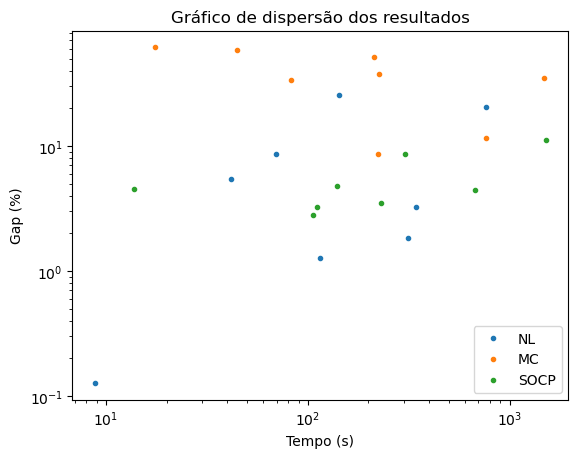

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [385]:
graph_dispersion(cases_no_sdp,sdp=false)